# Reinforcement Learning

In [1]:
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
%matplotlib inline
sns.set_palette('GnBu_d')
sns.set_style('whitegrid')

## Creating Environment

In [2]:
env = gym.make("CartPole-v0")
obs = env.reset()

In [3]:
obs

array([-0.04579889,  0.04716483, -0.0165984 , -0.01967517])

## Defining Parameters

In [4]:
n_inputs = 4
n_hidden = 4
n_outputs = 1
learning_rate = 0.01
initializer = tf.variance_scaling_initializer()

## Defining Placeholders

In [5]:
tf.reset_default_graph()
tf.set_random_seed(777)

with tf.name_scope('inputs'):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs])

## Defining Layers

In [6]:
with tf.name_scope('dnn'):
    hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
    logits = tf.layers.dense(hidden, n_outputs)
    outputs = tf.nn.sigmoid(logits)
    p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
    action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)
    y = 1. - tf.to_float(action)

## Defining Loss Function

In [7]:
with tf.name_scope('loss'):
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

## Training Model

In [8]:
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    grads_and_vars = optimizer.compute_gradients(cross_entropy)
    gradients = [grad for grad, variable in grads_and_vars]
    gradient_placeholders = []
    grads_and_vars_feed = []
    for grad, variable in grads_and_vars:
        gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
        gradient_placeholders.append(gradient_placeholder)
        grads_and_vars_feed.append((gradient_placeholder, variable))    
    training_op = optimizer.minimize(cross_entropy)

## Running Model

In [9]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [10]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

In [18]:
n_games_per_update = 10
n_max_steps = 1000
n_iterations = 250
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                print(obs.reshape(1, n_inputs))
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            save_path = saver.save(sess, './Models/tf_rl_example.ckpt')
            
env.close()            

Iteration: 249

## Visualising Model

In [12]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

In [13]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = env.render(mode="rgb_array")
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames

INFO:tensorflow:Restoring parameters from ./Models/tf_rl_example.ckpt


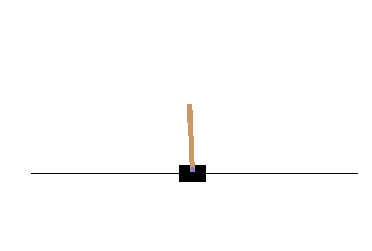

In [21]:
frames = render_policy_net(save_path, action, X)
video = plot_animation(frames)
plt.show()